In [21]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from sklearn.externals import joblib

In [22]:
df=pd.read_csv('final.csv')

In [23]:
df.shape

(431420, 32)

In [24]:
df.columns

Index(['DAY_OF_WEEK', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN', 'DEST',
       'DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DISTANCE',
       'DEP_HOUR', 'ARR_HOUR', 'YEAR', 'MONTH', 'DAY_OF_MONTH',
       'DEP_HOURLYVISIBILITY', 'DEP_HOURLYDRYBULBTEMPC', 'DEP_HOURLYWindSpeed',
       'DEP_HOURLYPrecip', 'ARR_HOURLYVISIBILITY', 'ARR_HOURLYDRYBULBTEMPC',
       'ARR_HOURLYWindSpeed', 'ARR_HOURLYPrecip', 'DEP_AVG_HOURLYVISIBILITY',
       'DEP_AVG_HOURLYDRYBULBTEMPC', 'DEP_AVG_HOURLYWindSpeed',
       'DEP_AVG_HOURLYPrecip', 'ARR_AVG_HOURLYVISIBILITY',
       'ARR_AVG_HOURLYDRYBULBTEMPC', 'ARR_AVG_HOURLYWindSpeed',
       'ARR_AVG_HOURLYPrecip'],
      dtype='object')

In [25]:
df.dtypes

DAY_OF_WEEK                     int64
FL_DATE                        object
UNIQUE_CARRIER                 object
FL_NUM                          int64
ORIGIN                         object
DEST                           object
DEP_DELAY                     float64
ARR_DELAY                     float64
CANCELLED                     float64
CANCELLATION_CODE             float64
DISTANCE                      float64
DEP_HOUR                        int64
ARR_HOUR                        int64
YEAR                            int64
MONTH                           int64
DAY_OF_MONTH                    int64
DEP_HOURLYVISIBILITY          float64
DEP_HOURLYDRYBULBTEMPC        float64
DEP_HOURLYWindSpeed           float64
DEP_HOURLYPrecip              float64
ARR_HOURLYVISIBILITY          float64
ARR_HOURLYDRYBULBTEMPC        float64
ARR_HOURLYWindSpeed           float64
ARR_HOURLYPrecip              float64
DEP_AVG_HOURLYVISIBILITY      float64
DEP_AVG_HOURLYDRYBULBTEMPC    float64
DEP_AVG_HOUR

In [26]:
df.drop(['YEAR','DAY_OF_MONTH','FL_NUM','DEP_DELAY','DEP_AVG_HOURLYVISIBILITY','DEP_AVG_HOURLYDRYBULBTEMPC','DEP_AVG_HOURLYWindSpeed','DEP_AVG_HOURLYPrecip','ARR_AVG_HOURLYVISIBILITY','ARR_AVG_HOURLYDRYBULBTEMPC','ARR_AVG_HOURLYWindSpeed','ARR_AVG_HOURLYPrecip'],axis=1, inplace=True)
#Remove data redundancy
df['ARR_HOUR'] = df['ARR_HOUR'].apply(lambda x:0 if x == 24 else x)
#Drop rows with Null Values
df.dropna(axis='columns')

#Convert to Dummy Variables
df = pd.concat([df,pd.get_dummies(df['MONTH'],drop_first=True,prefix="MONTH")],axis=1)
df = pd.concat([df,pd.get_dummies(df['DAY_OF_WEEK'],drop_first=True,prefix="DAY_OF_WEEK")],axis=1)
df = pd.concat([df,pd.get_dummies(df['UNIQUE_CARRIER'],drop_first=True,prefix="UNIQUE_CARRIER")],axis=1)
df = pd.concat([df,pd.get_dummies(df['ORIGIN'],drop_first=True,prefix="ORIGIN")],axis=1)
df = pd.concat([df,pd.get_dummies(df['DEST'],drop_first=True,prefix="DEST")],axis=1)
df = pd.concat([df,pd.get_dummies(df['DEP_HOUR'],drop_first=True,prefix="DEP_HOUR")],axis=1)
df = pd.concat([df,pd.get_dummies(df['ARR_HOUR'],drop_first=True,prefix="ARR_HOUR")],axis=1)

df.drop(['MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','ORIGIN','DEST','DEP_HOUR','ARR_HOUR'],axis=1,inplace=True)
#DELAY_YN -> Delay Yes or No -> 1 if Delay>5 minutes, else 0
df['DELAY_YN'] = df['ARR_DELAY'].apply(lambda x:1 if x>=5 else 0)


In [27]:
df.shape

(431420, 96)

In [48]:
df.columns

Index(['ARR_DELAY', 'CANCELLED', 'DISTANCE', 'DEP_HOURLYVISIBILITY',
       'DEP_HOURLYDRYBULBTEMPC', 'DEP_HOURLYWindSpeed', 'DEP_HOURLYPrecip',
       'ARR_HOURLYVISIBILITY', 'ARR_HOURLYDRYBULBTEMPC', 'ARR_HOURLYWindSpeed',
       'ARR_HOURLYPrecip', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'UNIQUE_CARRIER_AA',
       'UNIQUE_CARRIER_AS', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_MQ', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OH', 'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA',
       'UNIQUE_CARRIER_WN', 'UNIQUE_CARRIER_YV', 'UNIQUE_CARRIER_YX',
       'ORIGIN_CLT', 'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_IAH', 'ORIGIN_LAX',
       'ORIGIN_LGA', 'ORIGIN_ORD', 'ORIGIN_PHX', 'ORIGIN_SFO', 'DEST_CLT',
       'DEST_DEN', 'DEST_DFW', 'DEST_IAH', 'DEST_LAX', 'DEST_LGA', 'DEST_ORD',
       'DEST_PHX', 'DEST_SFO', 'DEP_HOUR_1', 'DEP_HOUR_2', 'DEP_HOUR_4',
       'DEP_HOUR_5', 'DEP_HOUR_6',

In [28]:
df.drop(['FL_DATE','CANCELLATION_CODE'],axis=1,inplace=True)

In [29]:
df.isnull().sum()

ARR_DELAY                     0
CANCELLED                     0
DISTANCE                      0
DEP_HOURLYVISIBILITY      35266
DEP_HOURLYDRYBULBTEMPC    35266
DEP_HOURLYWindSpeed       35266
DEP_HOURLYPrecip          35266
ARR_HOURLYVISIBILITY      35321
ARR_HOURLYDRYBULBTEMPC    35321
ARR_HOURLYWindSpeed       35321
ARR_HOURLYPrecip          35321
DAY_OF_WEEK_2                 0
DAY_OF_WEEK_3                 0
DAY_OF_WEEK_4                 0
DAY_OF_WEEK_5                 0
DAY_OF_WEEK_6                 0
DAY_OF_WEEK_7                 0
UNIQUE_CARRIER_AA             0
UNIQUE_CARRIER_AS             0
UNIQUE_CARRIER_DL             0
UNIQUE_CARRIER_EV             0
UNIQUE_CARRIER_F9             0
UNIQUE_CARRIER_MQ             0
UNIQUE_CARRIER_NK             0
UNIQUE_CARRIER_OH             0
UNIQUE_CARRIER_OO             0
UNIQUE_CARRIER_UA             0
UNIQUE_CARRIER_WN             0
UNIQUE_CARRIER_YV             0
UNIQUE_CARRIER_YX             0
                          ...  
DEP_HOUR

In [30]:
df = df[pd.notnull(df['DEP_HOURLYVISIBILITY'])]
df = df[pd.notnull(df['ARR_HOURLYVISIBILITY'])]

In [31]:
np.nan_to_num(df)

array([[  -2.,    0.,  544., ...,    0.,    0.,    0.],
       [ -13.,    0.,  544., ...,    0.,    0.,    0.],
       [ -21.,    0.,  544., ...,    0.,    0.,    0.],
       ..., 
       [  11.,    0.,  762., ...,    0.,    0.,    1.],
       [ -17.,    0.,  762., ...,    0.,    0.,    0.],
       [   3.,    0.,  762., ...,    0.,    0.,    0.]])

In [32]:
df.fillna(df.mean(), inplace=True)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

n = 10 
for i in range(n):
    
    
    df_split = df.loc[np.random.choice(df[df['DELAY_YN']==1].index, 40000, replace = True)]
    df_split2 = df.loc[np.random.choice(df[df['DELAY_YN']==0].index, 60000, replace = False)]
    df_split = df_split.append(df_split2, ignore_index=True)

    X_train, X_test, y_train, y_test = train_test_split(df_split.drop(['DELAY_YN','ARR_DELAY'],axis=1),
                                                    df_split['DELAY_YN'], test_size=0.10, random_state=101)

    logmodel = LogisticRegression()
    logmodel.fit(X_train,y_train)
    
    predictions = logmodel.predict(X_test)

    truePos = X_test[((predictions == 1) & (y_test == predictions))]
    falsePos = X_test[((predictions == 1) & (y_test != predictions))]
    trueNeg = X_test[((predictions == 0) & (y_test == predictions))]
    falseNeg = X_test[((predictions == 0) & (y_test != predictions))]

    TP = truePos.shape[0]
    FP = falsePos.shape[0]
    TN = trueNeg.shape[0]
    FN = falseNeg.shape[0]

    accuracy = float(TP + TN)/float(TP + TN + FP + FN)
    print('Accuracy: '+str(accuracy))
    
    joblib.dump(logmodel, str(i)+'_logmodel.pkl') 

Accuracy: 0.6778
Accuracy: 0.6967
Accuracy: 0.6824
Accuracy: 0.6823
Accuracy: 0.6979
Accuracy: 0.7114
Accuracy: 0.7059
Accuracy: 0.711
Accuracy: 0.673
Accuracy: 0.6973


In [30]:

df2 = df.loc[np.random.choice(df.index, 100000, replace = False)]
X_test = df2.drop(['ARR_DELAY','DELAY_YN'],axis=1)
y_test = df2['DELAY_YN']

n = 10 #Number of models to average over
df2['DELAY_YN'] = np.zeros(len(df2.index))

for i in range(n):
    logmodel = joblib.load(str(i)+'_logmodel.pkl') 
    predictions = logmodel.predict(X_test)
    
    df2['DELAY_YN'] = df2['DELAY_YN'] + logmodel.predict_proba(X_test)[:,1]
    
    truePos = X_test[((predictions == 1) & (y_test == predictions))]
    falsePos = X_test[((predictions == 1) & (y_test != predictions))]
    trueNeg = X_test[((predictions == 0) & (y_test == predictions))]
    falseNeg = X_test[((predictions == 0) & (y_test != predictions))]

    TP = truePos.shape[0]
    FP = falsePos.shape[0]
    TN = trueNeg.shape[0]
    FN = falseNeg.shape[0]

    accuracy = float(TP + TN)/float(TP + TN + FP + FN)
    print('Accuracy: '+str(accuracy))

Accuracy: 0.70363
Accuracy: 0.7197
Accuracy: 0.70575
Accuracy: 0.70323
Accuracy: 0.71674
Accuracy: 0.73263
Accuracy: 0.72397
Accuracy: 0.73458
Accuracy: 0.70042
Accuracy: 0.72324


In [31]:
#Take Average of probabilities for positive class (DELAY_YN = 1). If average probability>0.5, assign value=1
df2['DELAY_YN_vote'] = df2['DELAY_YN']/n
df2['DELAY_YN_vote'] = df2['DELAY_YN_vote'].apply(lambda x:1 if x>0.46 else 0) #Take Vote

truePos = X_test[((df2['DELAY_YN_vote'] == 1) & (y_test == df2['DELAY_YN_vote']))]
falsePos = X_test[((df2['DELAY_YN_vote'] == 1) & (y_test != df2['DELAY_YN_vote']))]
trueNeg = X_test[((df2['DELAY_YN_vote'] == 0) & (y_test == df2['DELAY_YN_vote']))]
falseNeg = X_test[((df2['DELAY_YN_vote'] == 0) & (y_test != df2['DELAY_YN_vote']))]

TP = truePos.shape[0]
FP = falsePos.shape[0]
TN = trueNeg.shape[0]
FN = falseNeg.shape[0]

accuracy = float(TP + TN)/float(TP + TN + FP + FN)
print('Final Accuracy: '+str(accuracy))
print('TP: '+str(TP))
print('FP: '+str(FP))
print('TN: '+str(TN))
print('FN: '+str(FN))
print('% of positive predictions:')
print(len(df2[df2['DELAY_YN_vote']==1].index)/len(df2.index))

Final Accuracy: 0.70811
TP: 18426
FP: 13004
TN: 52385
FN: 16185
% of positive predictions:
0.3143


In [33]:
#Linear Regression on whole dataset
df_late = df[df['DELAY_YN']==1].copy()
df_late['log_delay'] = np.log(df_late['ARR_DELAY'])

print('Total positive delay datapoints:' + str(len(df_late.index)))

Total positive delay datapoints:125829


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_late.drop(['DELAY_YN','log_delay'],axis=1), 
                                                    df_late['log_delay'], test_size=0.30, random_state=101)

print('Training...')
from sklearn.linear_model import LinearRegression
lm = LinearRegression(normalize=True)
lm.fit(X_train.drop('ARR_DELAY',axis=1),y_train)

print('Predicting on test set...')
predictions = lm.predict(X_test.drop('ARR_DELAY',axis=1))

X_test['predicted']=[np.exp(p) for p in predictions]

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(X_test['ARR_DELAY'],X_test['predicted']))
print('MSE:', metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted'])))

joblib.dump(lm, 'linearmodel.pkl')

Training...
Predicting on test set...
MAE: 27.8650793244
MSE: 4460.75219248
RMSE: 66.7888627877


['linearmodel.pkl']

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_late.drop(['DELAY_YN','log_delay'],axis=1), 
                                                    df_late['log_delay'], test_size=0.30, random_state=101)
print('Training...')
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators= 3000, max_depth= 5)
rf.fit(X_train.drop('ARR_DELAY',axis=1),y_train)

print('Predicting on test set...')
predictions2 = rf.predict(X_test.drop('ARR_DELAY',axis=1))

X_test['predicted']=[np.exp(p) for p in predictions2]

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(X_test['ARR_DELAY'],X_test['predicted']))
print('MSE:', metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted'])))

joblib.dump(rf, 'linearmodel2.pkl')

Training...
Predicting on test set...
MAE: 29.8835569275
MSE: 4939.57130881
RMSE: 70.2820838394


['linearmodel2.pkl']

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_late.drop(['DELAY_YN','log_delay'],axis=1), 
                                                    df_late['log_delay'], test_size=0.30, random_state=101)
print('Training...')
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth= 5)
dtr.fit(X_train.drop('ARR_DELAY',axis=1),y_train)

print('Predicting on test set...')
predictions3 = dtr.predict(X_test.drop('ARR_DELAY',axis=1))

X_test['predicted']=[np.exp(p) for p in predictions3]

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(X_test['ARR_DELAY'],X_test['predicted']))
print('MSE:', metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted'])))

joblib.dump(dtr, 'linearmodeldtr.pkl')

Training...
Predicting on test set...
MAE: 29.9851758996
MSE: 4960.71630964
RMSE: 70.4323527197


['linearmodeldtr.pkl']

In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_late.drop(['DELAY_YN','log_delay'],axis=1), 
                                                    df_late['log_delay'], test_size=0.30, random_state=101)


print('Training...')
xg_reg = xgb.XGBRegressor(n_estimators= 3000, max_depth= 5,learning_rate =0.1)
xg_reg.fit(X_train.drop('ARR_DELAY',axis=1),y_train)

print('Predicting on test set...')
predictions4 = xg_reg.predict(X_test.drop('ARR_DELAY',axis=1))

X_test['predicted']=[np.exp(p) for p in predictions4]

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(X_test['ARR_DELAY'],X_test['predicted']))
print('MSE:', metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test['ARR_DELAY'],X_test['predicted'])))

Training...
Predicting on test set...
MAE: 6.14102985453
MSE: 155.763966643
RMSE: 12.4805435235


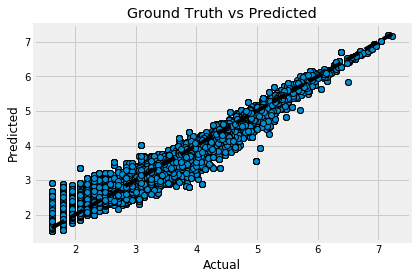

In [43]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_test,predictions4, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [47]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(X_test['ARR_DELAY'].values, predictions4)
roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported